In [1]:
%load_ext autoreload
%autoreload 2

In [147]:
import glob
import statsmodels.api as sm
from saturation.utils import *

In [3]:
n_cores = 28

spark = (SparkSession.builder
         .master(f"local[{n_cores}]")
         .appName("Saturation")
         .config("spark.sql.shuffle.partitions", "500")
         .config("spark.driver.memory", "60g")
         .config("spark.driver.maxResultSize", "8g")
         .getOrCreate())

24/09/01 17:01:26 WARN Utils: Your hostname, muninn resolves to a loopback address: 127.0.1.1; using 192.168.50.14 instead (on interface enp8s0)
24/09/01 17:01:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/01 17:01:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/09/01 17:01:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [40]:
base_path = "/data/saturation/thesis_run_20240726_single_sims/"

colors = ["black", "r", "orange", "g"]
line_styles = ["-"]
font_size = 16

configs_df = create_configs_df(read_configs(base_path, spark))
configs_pdf = configs_df.toPandas()

# For stats, select only fields we care about, alias them
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
data = data.select(
    "simulation_id",
    "ntot",
    "nobs",
    "mnnd",
    "z",
    "za",
    "radius_mean",
    "radius_stdev",
    F.col("areal_density").alias("ad"),
    F.log10("mnnd").alias("log_mnnd"),
    F.log10("nobs").alias("log_nobs"),
    F.log10("ntot").alias("log_ntot"),
).where(F.col("ntot") > 1)

# Join with configs to get simulation parameters
data = join_configs(data, configs_df, spark)

In [5]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/config*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

In [6]:
def plot_metric(
    data: pd.DataFrame,
    x_var: str,
    x_label: str,
    y_var: str,
    y_label: str,
    dotted_horizontal_lines: list[float] = None
):
    font_size = 16

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)

    simulation_ids = data.simulation_id.drop_duplicates()
    for idx, simulation_id in enumerate(simulation_ids):
        data_subset = data[data.simulation_id == simulation_id].sort_values("ntot")
        ax.plot(
            data_subset[x_var],
            data_subset[y_var],
            c=colors[idx % len(colors)],
            ls=line_styles[idx % len(line_styles)]
        )

    if dotted_horizontal_lines:
        for y_val in dotted_horizontal_lines:
            ax.axhline(y_val, color="r", linestyle="--")
    
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)

    return fig


def get_states_at_ntots(
    *,
    simulation_id: int,
    configs_dict: Dict,
    base_path: str,
    target_ntots: Optional[List[int]]=None,
    max_ntot: Optional[int]=int(1e6)
) -> Dict[int, pd.DataFrame]:
    """
    Returns a dict from values of ntot (a moment in time) to a dataframe of crater locations and radii at that time.
    """
    n_states = 25
    
    if not target_ntots:  
        target_ntots = [int(10**2 * 10**((x + 1) / n_states * (np.log10(max_ntot) - 2))) for x in range(n_states)]
        
    study_region_size = configs_dict[simulation_id]["study_region_size"]
    study_region_padding = configs_dict[simulation_id]["study_region_padding"]
    
    sim_name = configs_dict[simulation_id]["simulation_name"]
    sim_path = f"{base_path}/{sim_name}"
    
    stats_df = spark.read.parquet(f"{sim_path}/statistics_*.parquet")
    craters_df = spark.read.parquet(f"{sim_path}/craters_*.parquet")
    removals_df = spark.read.parquet(f"{sim_path}/crater_removals_*.parquet")
    
    return {
        x: get_state_at_time(
            stats_df,
            craters_df,
            removals_df,
            simulation_id,
            x,
            study_region_size,
            study_region_padding,
            spark
        )
        for x in target_ntots
    }


def estimate_slopes_for_states(states: Dict[int, pd.DataFrame]) -> pd.DataFrame:
    estimates = []
    for ntot, state in states.items():
        state = states[ntot]
        alpha, sigma = estimate_cumulative_slope(
            state.radius,
            configs_dict[simulation_id]["min_crater_radius"],
            state.radius.max(),
            min_search_slope=0.0,
            max_search_slope=10.0)
        estimates.append({
            "ntot": ntot,
            "alpha": alpha,
            "sigma": sigma,
        })
    return pd.DataFrame(estimates)


def plot_slope_estimates(estimates_df: pd.DataFrame):
    font_size = 16

    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111)
    
    ax.errorbar(
        estimates_df.ntot,
        estimates_df.alpha,
        estimates_df.sigma,
        ls="None",
        marker="+"
    )
    ax.set_xlabel("$N_{tot}$", fontsize=font_size)
    ax.set_ylabel("$b$", fontsize=font_size)
    ax.set_xscale("log")
    
    return fig


def plot_metrics(
    *,
    df: pd.DataFrame,
    scenario_name: str,
    ntot_bound_saturation: int
):
    ad_line = df[df.ntot > ntot_bound_saturation].ad.mean()
    print(f"AD line: {ad_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "ad",
        "$A_d$",
        dotted_horizontal_lines=[ad_line]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_ad.png", bbox_inches="tight")
    
    log_mnnd_line = df[df.ntot > ntot_bound_saturation].log_mnnd.mean()
    print(f"log_mnnd line: {log_mnnd_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "log_mnnd",
        "$log_{10}(\\overline{NN}_d)$",
        dotted_horizontal_lines=[log_mnnd_line]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_mnnd.png", bbox_inches="tight")
    
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "z",
        "$Z$",
        dotted_horizontal_lines=[-1.96, 1.96]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_z.png", bbox_inches="tight")
    
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "za",
        "$Z_a$",
        dotted_horizontal_lines=[-1.96, 1.96]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_za.png", bbox_inches="tight")
    
    radius_mean_line = df[df.ntot > ntot_bound_saturation].radius_mean.mean()
    print(f"radius_mean line: {radius_mean_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "radius_mean",
        "$\\overline{r}$",
        dotted_horizontal_lines=[radius_mean_line]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_radius_mean.png", bbox_inches="tight")
    
    radius_stdev_line = df[df.ntot > ntot_bound_saturation].radius_stdev.mean()
    print(f"radius_stdev line: {radius_stdev_line}")
    fig = plot_metric(
        df,
        "ntot",
        "$N_{tot}$",
        "radius_stdev",
        "$\\sigma_r$",
        dotted_horizontal_lines=[radius_stdev_line]
    )
    plt.show()
    fig.savefig(f"figures/{scenario_name}_ntot_radius_stdev.png", bbox_inches="tight")

In [113]:
def get_lifetimes_for_simulation(
    simulation_id: int,
    base_path: str,
    sample_fraction: float
) -> pd.DataFrame:
    craters = spark.read.parquet(f"{base_path}/*/craters_*.parquet").sample(sample_fraction)
    removals = spark.read.parquet(f"{base_path}/*/crater_removals_*.parquet")
    configs_df = F.broadcast(create_configs_df(read_configs(base_path, spark, completed_only=False)))
    
    configs_df.createOrReplaceTempView("config")
    craters.createOrReplaceTempView("craters")
    removals.createOrReplaceTempView("removals")
    
    query = f"""
    WITH lifetimes AS
    (
        SELECT
            simulation_id,
            removed_crater_id AS id,
            removed_by_crater_id - removed_crater_id AS lifetime
        FROM
            removals
    ),
    craters AS
    (
        SELECT
            c.simulation_id,
            c.id,
            radius
        FROM
            craters c
            INNER JOIN config cfg ON
                c.simulation_id = cfg.simulation_id
        WHERE
            1=1
            AND c.x BETWEEN study_region_padding AND study_region_size + study_region_padding
            AND c.y BETWEEN study_region_padding AND study_region_size + study_region_padding
    )
    SELECT
        radius,
        lifetime
    FROM
        lifetimes l
        INNER JOIN craters c ON
            c.id = l.id
            AND c.simulation_id = l.simulation_id
    WHERE
        l.simulation_id = {selected_simulation_id}
    ORDER BY
        radius
    """
    return spark.sql(query).toPandas()

# Comparisons of scenarios

## Steep vs shallow slopes

In [213]:
# Select a steep sloped sim
steep_slope = -4
filtered = configs_pdf[configs_pdf.slope == steep_slope]
steep_slope_id = filtered.simulation_id.iloc[0]
filtered

,erat,mrp,rmult,simulation_id,slope,study_region_padding,study_region_size
0,9,0.5,1.5,23,-4.0,250,2000
2,9,0.5,1.5,22,-4.0,250,2000
10,3,0.5,1.5,54,-4.0,250,2000
11,9,0.5,1.5,21,-4.0,250,2000


In [214]:
# Select a shallow sloped sim
shallow_slope = -1
filtered = configs_pdf[configs_pdf.slope == shallow_slope]
shallow_slope_id = filtered.simulation_id.iloc[0]
filtered

,erat,mrp,rmult,simulation_id,slope,study_region_padding,study_region_size
6,9,0.5,1.5,2,-1.0,250,2000
7,9,0.5,1.5,1,-1.0,250,2000
15,9,0.5,1.5,3,-1.0,250,2000


nobs line: 366.0


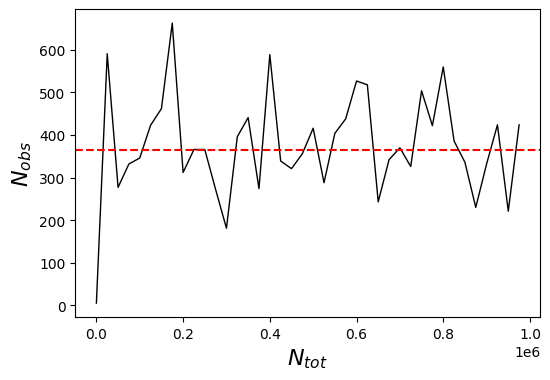

In [206]:
scenario_name = "shallow_slope"
selected_simulation_id = 1
simulation_ids = [selected_simulation_id]

max_ntot = 1000000

sample_rate = 25000
df = data.where(
    F.col("simulation_id").isin(simulation_ids)
    & (F.col("ntot") % sample_rate == 5)
    & (F.col("ntot") < max_ntot)
).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[df.ntot > 50000].nobs.median()
print(f"nobs line: {nobs_line}")

for idx, simulation_id in enumerate(simulation_ids):
    df_subset = df[df.simulation_id == simulation_id]
    plt1 = ax1.plot(
        df_subset.ntot,
        df_subset.nobs,
        label="$N_{obs}$",
        lw=1,
        c=colors[idx % len(colors)],
        ls=line_styles[idx % len(line_styles)]
    )

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

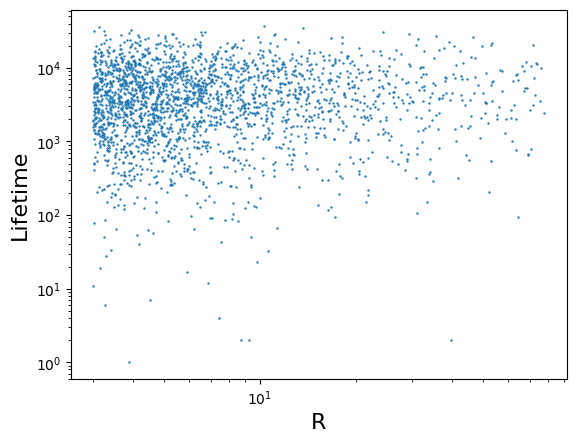

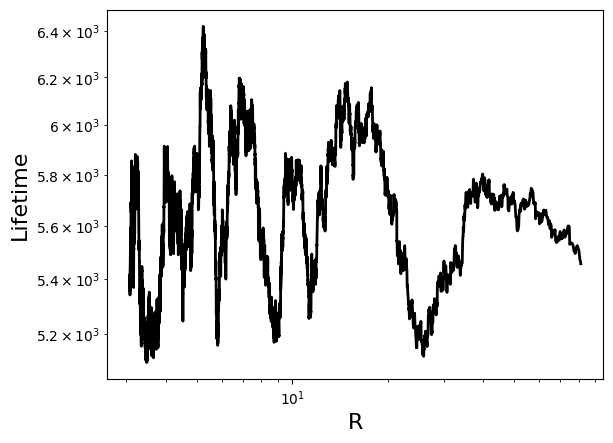

<Figure size 640x480 with 0 Axes>

In [208]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 0.01)

# Sampled scatterplot
sampled = lifetimes[lifetimes.radius < smoothed_radii.max()].sample(frac=0.25)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    s=.5
)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("R", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

# Smoothed plot with fitted line
n_smoothing = 500
min_periods = 100
smoothed_radii = lifetimes.radius.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
smoothed_lifetimes = lifetimes.lifetime.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
plt.plot(
    smoothed_radii,
    smoothed_lifetimes,
    c="black",
    label="Smoothed",
    lw=2
)
plt.xlabel("R", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)

# # Fit the line in log space
# fitted_model = sm.OLS(np.log(smoothed_lifetimes), sm.add_constant(np.log(smoothed_radii))).fit()
# const, fitted_slope = fitted_model.params

# fitted = smoothed_radii ** fitted_slope * np.e**const 
# plt.plot(
#     smoothed_radii,
#     fitted,
#     ls="dashed",
#     label=f"$R^{{ {fitted_slope:.2} }}$"
# )
plt.xscale("log")
plt.yscale("log")
# plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_smoothed.png", bbox_inches="tight")

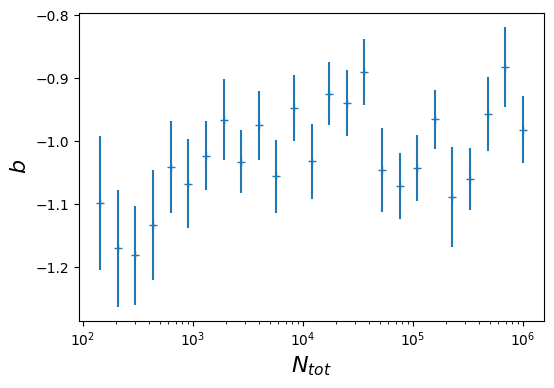

In [111]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path)
slope_estimates = estimate_slopes_for_states(states)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
# Scatter plot of crater centers at a given ntot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, study_region_size])
ax.set_ylim([0, study_region_size])

s = states[max(states.keys())]

ax.scatter(s.x - study_region_padding, s.y - study_region_padding, s=0.5)

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[500, 1000, 1000000])

reference_slope = -1.0
intercept = max(state.shape[0] / state.radius.min()**reference_slope for state in states.values())
slope_intercept_line_styles = [
    (reference_slope, intercept, "--")
]

fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

In [ ]:
max_ntot = 10000

sample_rate = 100
df = data.where(
    F.col("simulation_id").isin(simulation_ids)
    & (F.col("ntot") % sample_rate == 5)
    & (F.col("ntot") < max_ntot)
).orderBy("ntot").toPandas()

plot_metrics(
    df=df,
    scenario_name="shallow_slope",
    ntot_bound_saturation=8000
)

## Plots of individual simulations vs N_tot, steep slope

In [197]:
selected_slope = -4.0
configs_pdf[configs_pdf.slope == selected_slope]

,erat,mrp,rmult,simulation_id,slope,study_region_padding,study_region_size
0,9,0.5,1.5,23,-4.0,250,2000
2,9,0.5,1.5,22,-4.0,250,2000
10,3,0.5,1.5,54,-4.0,250,2000
11,9,0.5,1.5,21,-4.0,250,2000


nobs line: 562.5


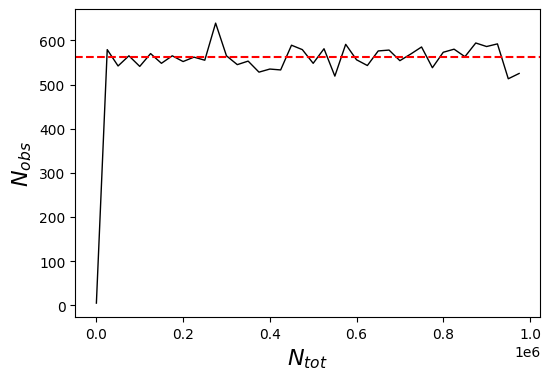

In [198]:
scenario_name = "steep_slope"
selected_simulation_id = 23
simulation_ids = [selected_simulation_id] #list(configs_pdf[configs_pdf.slope == -4].simulation_id)

max_ntot = 1000000

sample_rate = 25000
df = data.where(
    F.col("simulation_id").isin(simulation_ids)
    & (F.col("ntot") % sample_rate == 5)
    & (F.col("ntot") < max_ntot)
).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[df.ntot > 50000].nobs.median()
print(f"nobs line: {nobs_line}")

for idx, simulation_id in enumerate(simulation_ids):
    df_subset = df[df.simulation_id == simulation_id]
    plt1 = ax1.plot(
        df_subset.ntot,
        df_subset.nobs,
        label="$N_{obs}$",
        lw=1,
        c=colors[idx % len(colors)],
        ls=line_styles[idx % len(line_styles)]
    )

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

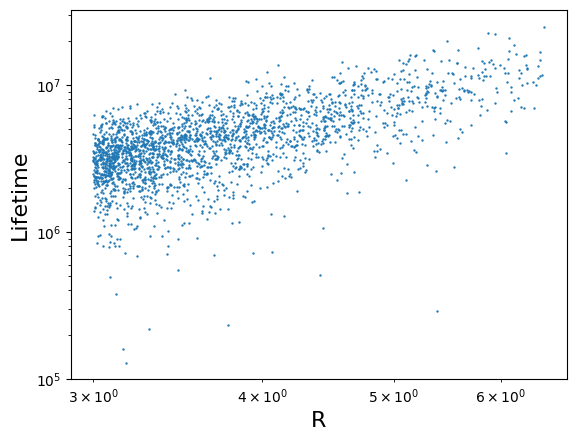

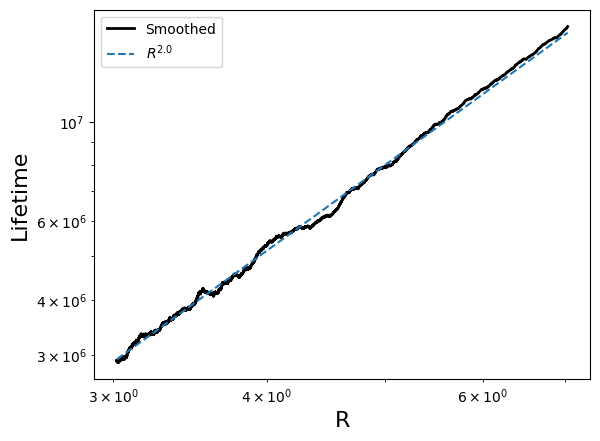

<Figure size 640x480 with 0 Axes>

In [204]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 0.01)

# Sampled scatterplot
sampled = lifetimes[lifetimes.radius < smoothed_radii.max()].sample(frac=0.25)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    s=.5
)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("R", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)
plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

# Smoothed plot with fitted line
n_smoothing = 500
min_periods = 100
smoothed_radii = lifetimes.radius.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
smoothed_lifetimes = lifetimes.lifetime.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)[:-n_smoothing//4]
plt.plot(
    smoothed_radii,
    smoothed_lifetimes,
    c="black",
    label="Smoothed",
    lw=2
)
plt.xlabel("R", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)

# Fit the line in log space
fitted_model = sm.OLS(np.log(smoothed_lifetimes), sm.add_constant(np.log(smoothed_radii))).fit()
const, fitted_slope = fitted_model.params

fitted = smoothed_radii ** fitted_slope * np.e**const 
plt.plot(
    smoothed_radii,
    fitted,
    ls="dashed",
    label=f"$R^{{ {fitted_slope:.2} }}$"
)
plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.show()
plt.savefig(f"figures/{scenario_name}_lifetimes_smoothed.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path)
slope_estimates = estimate_slopes_for_states(states)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
# Scatter plot of crater centers at a given ntot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, study_region_size])
ax.set_ylim([0, study_region_size])

s = states[max(states.keys())]

ax.scatter(s.x - study_region_padding, s.y - study_region_padding, s=0.5)

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[250, 5000, 1000000])
r_max = 100000
states = {
    k: v[v.radius < r_max]
    for k, v in states.items()
}

equilibrium_slope = -2.0
equilibrium_intercept1 = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())
equilibrium_intercept2 = min(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -4.0
production_intercept1 = max(state.shape[0] / state.radius.min()**production_slope for state in states.values())
production_intercept2 = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept1, "--"),
    # (equilibrium_slope, equilibrium_intercept2, "--"),
    # (production_slope, production_intercept1, "dotted"),
    (production_slope, production_intercept2, "dotted"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

In [ ]:
max_ntot = 1000000

sample_rate = 5000
df = data.where(
    F.col("simulation_id").isin(simulation_ids)
    & (F.col("ntot") % sample_rate == 5)
    & (F.col("ntot") < max_ntot)
).orderBy("ntot").toPandas()

plot_metrics(
    df=df,
    scenario_name=scenario_name,
    ntot_bound_saturation=100000
)

## Plots of single simulations, high destruction, slope = -2.5

In [144]:
selected_slope = -2.5
configs_pdf[configs_pdf.slope == selected_slope]

,erat,mrp,rmult,simulation_id,slope,study_region_padding,study_region_size
1,9,0.50,1.5,13,-2.5,250,2000
3,15,0.75,1.9,41,-2.5,250,2000
4,3,0.25,1.1,31,-2.5,250,2000
8,3,0.25,1.1,32,-2.5,250,2000
9,15,0.75,1.9,42,-2.5,250,2000
12,3,0.50,1.5,51,-2.5,250,2000
13,15,0.75,1.9,43,-2.5,250,2000
14,3,0.25,1.1,33,-2.5,250,2000
16,9,0.50,1.5,12,-2.5,250,2000
17,9,0.50,1.5,11,-2.5,250,2000


nobs line: 1078.0


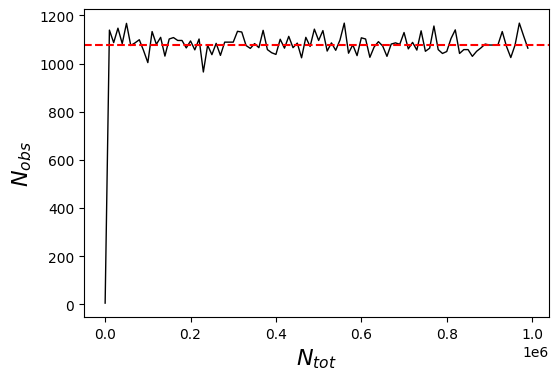

In [145]:
scenario_name = "high_destruction"
selected_simulation_id = 41
simulation_ids = [selected_simulation_id] #list(configs_pdf[configs_pdf.simulation_id.between(40, 50)].simulation_id)

max_ntot = 1000000

sample_rate = 10000
df = data.where(
    F.col("simulation_id").isin(simulation_ids)
    & (F.col("ntot") % sample_rate == 5)
    & (F.col("ntot") < max_ntot)
).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[df.ntot > 50000].nobs.median()
print(f"nobs line: {nobs_line}")

for idx, simulation_id in enumerate(simulation_ids):
    df_subset = df[df.simulation_id == simulation_id]
    plt1 = ax1.plot(
        df_subset.ntot,
        df_subset.nobs,
        label="$N_{obs}$",
        lw=1,
        c=colors[idx % len(colors)],
        ls=line_styles[idx % len(line_styles)]
    )

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [184]:
lifetimes = get_lifetimes_for_simulation(selected_simulation_id, base_path, 0.01)

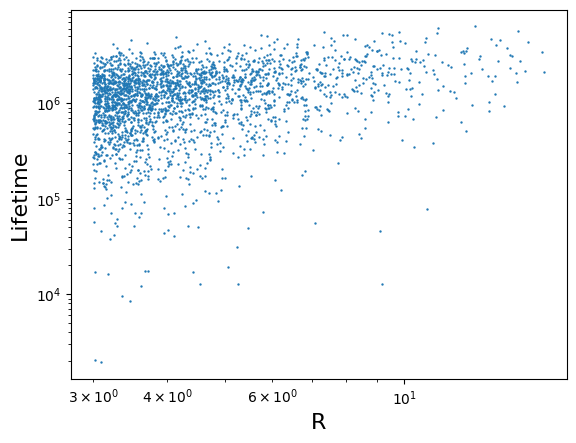

In [187]:
sampled = lifetimes[lifetimes.radius < smoothed_radii.max()].sample(frac=0.25)
plt.scatter(
    sampled.radius,
    sampled.lifetime,
    s=.5
)
plt.xscale("log")
plt.yscale("log")

plt.xlabel("R", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)

fig.savefig(f"figures/{scenario_name}_lifetimes_scatter.png", bbox_inches="tight")

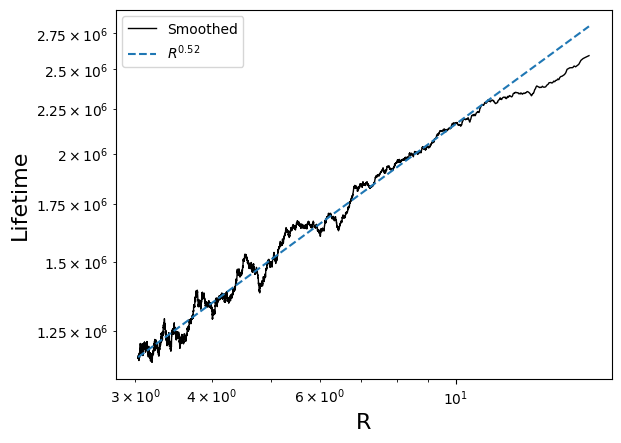

In [195]:
n_smoothing = 500
min_periods = 100
smoothed_radii = lifetimes.radius.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)
smoothed_lifetimes = lifetimes.lifetime.rolling(n_smoothing, center=True).mean().dropna().reset_index(drop=True)
plt.plot(
    smoothed_radii,
    smoothed_lifetimes,
    c="black",
    label="Smoothed",
    lw=1
)
plt.xlabel("R", fontsize=font_size)
plt.ylabel("Lifetime", fontsize=font_size)

# Fit the line in log space
fitted_model = sm.OLS(np.log(smoothed_lifetimes), sm.add_constant(np.log(smoothed_radii))).fit()
const, fitted_slope = fitted_model.params

fitted = smoothed_radii ** fitted_slope * np.e**const 
plt.plot(
    smoothed_radii,
    fitted,
    ls="dashed",
    label=f"$R^{{ {fitted_slope:.2} }}$"
)
plt.xscale("log")
plt.yscale("log")

plt.legend()

fig.savefig(f"figures/{scenario_name}_lifetimes.png", bbox_inches="tight")

In [175]:
1/np.e

0.36787944117144233

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path)
slope_estimates = estimate_slopes_for_states(states)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
# Scatter plot of crater centers at a given ntot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, study_region_size])
ax.set_ylim([0, study_region_size])

s = states[max(states.keys())]

ax.scatter(s.x - study_region_padding, s.y - study_region_padding, s=0.5)

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[1000, 3000, 1000000])
r_max = 100
states = {
    k: v[v.radius < r_max]
    for k, v in states.items()
}

equilibrium_slope = -2.0
equilibrium_intercept1 = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())
equilibrium_intercept2 = min(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept1 = max(state.shape[0] / state.radius.min()**production_slope for state in states.values())
production_intercept2 = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept1, "--"),
    # (equilibrium_slope, equilibrium_intercept2, "--"),
    # (production_slope, production_intercept1, "dotted"),
    (production_slope, production_intercept2, "dotted"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

In [ ]:
max_ntot = 1000000

sample_rate = max_ntot // 250
df = data.where(
    F.col("simulation_id").isin(simulation_ids)
    & (F.col("ntot") % sample_rate == 5)
    & (F.col("ntot") < max_ntot)
).orderBy("ntot").toPandas()

plot_metrics(
    df=df,
    scenario_name=scenario_name,
    ntot_bound_saturation=100000
)

## Plots of single simulations, low destruction, slope = -2.5

In [ ]:
# Locate simulations with shallow slopes
configs_pdf[configs_pdf.simulation_id.between(30, 40)]

In [ ]:
scenario_name = "low_destruction"
selected_simulation_id = 31
simulation_ids = list(configs_pdf[configs_pdf.simulation_id.between(31, 40)].simulation_id)

max_ntot = 1000000

sample_rate = 5000
df = data.where(
    F.col("simulation_id").isin(simulation_ids)
    & (F.col("ntot") % sample_rate == 5)
    & (F.col("ntot") < max_ntot)
).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[df.ntot > 50000].nobs.median()
print(f"nobs line: {nobs_line}")

for idx, simulation_id in enumerate(simulation_ids):
    df_subset = df[df.simulation_id == simulation_id]
    plt1 = ax1.plot(
        df_subset.ntot,
        df_subset.nobs,
        label="$N_{obs}$",
        lw=1,
        c=colors[idx % len(colors)],
        ls=line_styles[idx % len(line_styles)]
    )

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path)
slope_estimates = estimate_slopes_for_states(states)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
# Scatter plot of crater centers at a given ntot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, study_region_size])
ax.set_ylim([0, study_region_size])

s = states[max(states.keys())]

ax.scatter(s.x - study_region_padding, s.y - study_region_padding, s=0.5)

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[500, 5000, 100000])
r_max = 200
states = {
    k: v[v.radius < r_max]
    for k, v in states.items()
}

equilibrium_slope = -2.0
equilibrium_intercept1 = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())
equilibrium_intercept2 = min(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.5
production_intercept1 = max(state.shape[0] / state.radius.min()**production_slope for state in states.values())
production_intercept2 = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept1, "--"),
    # (equilibrium_slope, equilibrium_intercept2, "--"),
    # (production_slope, production_intercept1, "dotted"),
    (production_slope, production_intercept2, "dotted"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

In [ ]:
max_ntot = 1000000

sample_rate = max_ntot // 400
df = data.where(
    F.col("simulation_id").isin(simulation_ids)
    & (F.col("ntot") % sample_rate == 5)
    & (F.col("ntot") < max_ntot)
).orderBy("ntot").toPandas()

plot_metrics(
    df=df,
    scenario_name=scenario_name,
    ntot_bound_saturation=100000
)

## Extended simulation, shallow slope

In [ ]:
base_path = "/data/saturation/thesis_run_20240726_long_shallow_slope"

configs_df = create_configs_df(read_configs(base_path, spark))
configs_pdf = configs_df.toPandas()

# For stats, select only fields we care about, alias them
data = spark.read.parquet(f"{base_path}/*/statistics_*.parquet")
data = data.select(
    "simulation_id",
    "ntot",
    "nobs",
    "mnnd",
    "z",
    "za",
    "radius_mean",
    "radius_stdev",
    F.col("areal_density").alias("ad"),
    F.log10("mnnd").alias("log_mnnd"),
    F.log10("nobs").alias("log_nobs"),
    F.log10("ntot").alias("log_ntot"),
).where(F.col("ntot") > 1)

# Join with configs to get simulation parameters
data = join_configs(data, configs_df, spark)

In [ ]:
configs_dict = dict()
for config_file in glob.glob(f"{base_path}/config/thesis*.yaml"):
    for run_config in read_config(Path(config_file))["run_configurations"]:
        configs_dict.update(run_config)

In [ ]:
# Locate simulations with shallow slopes
configs_pdf[configs_pdf.slope == -1]

In [ ]:
scenario_name = "long_shallow_slope"
selected_simulation_id = 1
simulation_ids = [1]

max_ntot = 10000000

sample_rate = 50000
df = data.where(
    F.col("simulation_id").isin(simulation_ids)
    & (F.col("ntot") % sample_rate == 5)
    & (F.col("ntot") < max_ntot)
).orderBy("ntot").toPandas()

fig = plt.figure(figsize=(6, 4))
ax1 = fig.add_subplot(111)

nobs_line = df[df.ntot > 1000000].nobs.median()
print(f"nobs line: {nobs_line}")

for idx, simulation_id in enumerate(simulation_ids):
    df_subset = df[df.simulation_id == simulation_id]
    plt1 = ax1.plot(
        df_subset.ntot,
        df_subset.nobs,
        label="$N_{obs}$",
        lw=1,
        c=colors[idx % len(colors)],
        ls=line_styles[idx % len(line_styles)]
    )

ax1.axhline(nobs_line, color="r", linestyle="--")
ax1.set_ylabel("$N_{obs}$", fontsize=font_size)
ax1.set_xlabel("$N_{tot}$", fontsize=font_size)

plt.show()
fig.savefig(f"figures/{scenario_name}_ntot_nobs.png", bbox_inches="tight")

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, max_ntot=1e7)
slope_estimates = estimate_slopes_for_states(states)

fig = plot_slope_estimates(slope_estimates)
plt.show()
fig.savefig(f"figures/{scenario_name}_slope_estimates.png", bbox_inches="tight")

In [ ]:
# Scatter plot of crater centers at a given ntot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.set_xlim([0, study_region_size])
ax.set_ylim([0, study_region_size])

s = states[max(states.keys())]

ax.scatter(s.x - study_region_padding, s.y - study_region_padding, s=0.5)

In [ ]:
states = get_states_at_ntots(simulation_id=selected_simulation_id, configs_dict=configs_dict, base_path=base_path, target_ntots=[500, 100000, int(1e7)])
r_max = 10000
states = {
    k: v[v.radius < r_max]
    for k, v in states.items()
}

equilibrium_slope = -1.0
equilibrium_intercept1 = max(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())
equilibrium_intercept2 = min(state.shape[0] / state.radius.min()**equilibrium_slope for state in states.values())

production_slope = -2.0
production_intercept1 = max(state.shape[0] / state.radius.min()**production_slope for state in states.values())
production_intercept2 = min(state.shape[0] / state.radius.min()**production_slope for state in states.values())
slope_intercept_line_styles = [
    (equilibrium_slope, equilibrium_intercept1, "--"),
    # (equilibrium_slope, equilibrium_intercept2, "--"),
    (production_slope, production_intercept1, "dotted"),
    # (production_slope, production_intercept2, "dotted"),
]
fig = plot_csfds_for_multiple_ntot(states=states, slope_intercept_line_styles=slope_intercept_line_styles)
plt.show()
fig.savefig(f"figures/{scenario_name}_csfds.png", bbox_inches="tight")

In [ ]:
max_ntot = 10000000

sample_rate = max_ntot // 400
df = data.where(
    F.col("simulation_id").isin(simulation_ids)
    & (F.col("ntot") % sample_rate == 5)
    & (F.col("ntot") < max_ntot)
).orderBy("ntot").toPandas()

plot_metrics(
    df=df,
    scenario_name=scenario_name,
    ntot_bound_saturation=100000
)